In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, col, count, avg, year, to_date

# Crear sesión de Spark con soporte para Hive
spark = SparkSession.builder \
    .appName("Test Hive Connection") \
    .config("hive.metastore.uris", "thrift://172.17.0.2:9083") \
    .enableHiveSupport() \
    .getOrCreate()

def test_conection():
    try:
        spark.sql("SHOW DATABASES").show()
        print("Conexión exitosa a Hive")
    except Exception as e:
        print("Error en la conexión a Hive:", e)

test_conection()



24/06/19 09:42:22 WARN Utils: Your hostname, fabro-ryzen7800x resolves to a loopback address: 127.0.1.1; using 192.168.1.82 instead (on interface enp6s0)
24/06/19 09:42:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/19 09:42:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-------------+
|    namespace|
+-------------+
|   aviaciondb|
|car_rental_db|
|      default|
|     tripdata|
+-------------+

Conexión exitosa a Hive


In [2]:
df = spark.sql("SELECT * FROM car_rental_db.car_rental_analytics")

### a. Cantidad de alquileres de autos ecológicos (hibrido o eléctrico) con un rating de al menos 4

In [3]:
eco_rentals_count = df.filter((col("fueltype").isin("hybrid", "electric")) & (col("rating") >= 4)).count()
print(f"Cantidad de alquileres de autos ecológicos con un rating de al menos 4: {eco_rentals_count}") #3288

24/06/19 09:42:26 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


Cantidad de alquileres de autos ecológicos con un rating de al menos 4: 3288


### b. Los 5 estados con menor cantidad de alquileres

In [4]:
state_rentals = df.groupBy("state_name").count().orderBy(col("count").asc()).limit(5)
state_rentals.show()

+-------------+-----+
|   state_name|count|
+-------------+-----+
|      montana|    4|
|west virginia|   12|
|new hampshire|   12|
|  mississippi|   16|
|     arkansas|   16|
+-------------+-----+



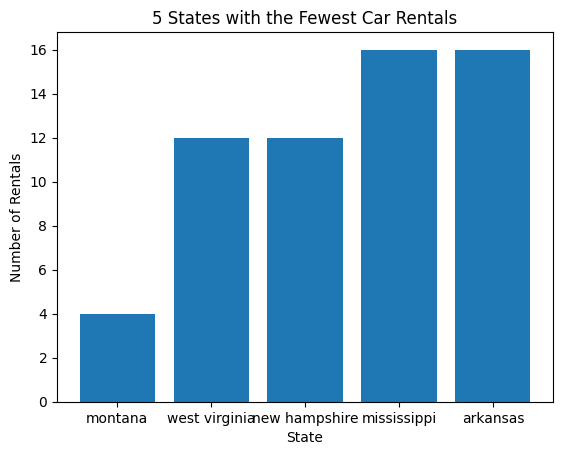

In [5]:
import matplotlib.pyplot as plt

state_rentals_pd = state_rentals.toPandas()
plt.bar(state_rentals_pd['state_name'], state_rentals_pd['count'])
plt.xlabel('State')
plt.ylabel('Number of Rentals')
plt.title('5 States with the Fewest Car Rentals')
plt.show()

### c. Los 10 modelos (junto con su marca) de autos más rentados


In [6]:
model_rentals = df.groupBy("make", "model").count().orderBy(col("count").desc()).limit(10)
model_rentals.show()

+-------------+--------+-----+
|         make|   model|count|
+-------------+--------+-----+
|        tesla| model 3| 1228|
|         ford| mustang|  564|
|        tesla| model s|  500|
|         jeep|wrangler|  460|
|        tesla| model x|  424|
|mercedes-benz| c-class|  392|
|       toyota| corolla|  388|
|          bmw|3 series|  332|
|    chevrolet|corvette|  296|
|       toyota|   camry|  292|
+-------------+--------+-----+



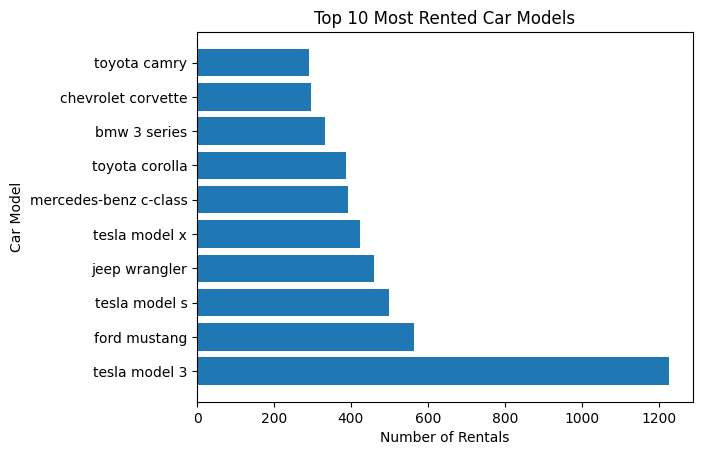

In [7]:
model_rentals_pd = model_rentals.toPandas()
plt.barh(model_rentals_pd['make'] + " " + model_rentals_pd['model'], model_rentals_pd['count'])
plt.xlabel('Number of Rentals')
plt.ylabel('Car Model')
plt.title('Top 10 Most Rented Car Models')
plt.show()

### d. Mostrar por año, cuántos alquileres se hicieron, teniendo en cuenta automóviles fabricados desde 2010 a 2015


In [8]:
# Convertir el año a un tipo de fecha temporal
df_with_date = df.withColumn("year_date", to_date(col("year").cast("string"), "yyyy"))

# Filtrar y agrupar por año
yearly_rentals = df_with_date.filter((col("year") >= 2010) & (col("year") <= 2015)) \
    .groupBy(year("year_date").alias("year")).count().orderBy("year")

yearly_rentals.show()

+----+-----+
|year|count|
+----+-----+
|2010|  648|
|2011|  904|
|2012| 1052|
|2013| 1376|
|2014| 1672|
|2015| 2312|
+----+-----+



### e. Las 5 ciudades con más alquileres de vehículos ecológicos (fuelType hibrido o electrico)


In [9]:
eco_city_rentals = df.filter(col("fueltype").isin("hybrid", "electric")) \
    .groupBy("city").count().orderBy(col("count").desc()).limit(5)
eco_city_rentals.show()

+---------+-----+
|     city|count|
+---------+-----+
|san diego|  176|
|las vegas|  136|
| portland|   84|
|  phoenix|   68|
| san jose|   60|
+---------+-----+



### f. El promedio de reviews, segmentando por tipo de combustible

In [10]:
average_reviews = df.groupBy("fueltype").agg(avg("reviewcount").alias("average_reviews"))
average_reviews.show()

+--------+------------------+
|fueltype|   average_reviews|
+--------+------------------+
|gasoline|31.643652055416762|
|    NULL|         20.296875|
|  diesel| 16.83606557377049|
|  hybrid| 35.41897233201581|
|electric|27.899824253075572|
+--------+------------------+



In [11]:
# Detener la sesión de Spark
spark.stop()